In [1]:
# Cell 1: Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from pathlib import Path
import sys

# Import project config for standardized paths
# Add project root to sys.path (go up 2 levels from notebooks/past_performance/)
sys.path.append(str(Path('../..').resolve()))
from config import CLEANED_DATA_PARQUET

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# Load cleaned data using config path
print(f"Loading data from: {CLEANED_DATA_PARQUET}")
pps_df = pd.read_parquet(CLEANED_DATA_PARQUET)

print("Data loaded successfully!")
print(f"Total rows: {len(pps_df):,}")
print(f"Total columns: {len(pps_df.columns)}")

Loading data from: /home/yler/GitHub/RaceLens/data/processed/cleaned_data.parquet
Data loaded successfully!
Total rows: 60,752
Total columns: 31


In [2]:
# Add DNF check after Cell 1

# Cell 1.5: DNF Check
print("\n" + "=" * 80)
print("DNF (Did Not Finish) CHECK")
print("=" * 80)

dnf_count = (pps_df['speed_figure'] == 999).sum()
print(f"Total DNF races: {dnf_count:,} ({dnf_count/len(pps_df)*100:.1f}%)")
print("Note: This analysis uses final_odds instead of speed_figure, so DNF impact is minimal")
print("However, we should still be aware of DNF rates for comprehensive analysis")


DNF (Did Not Finish) CHECK
Total DNF races: 311 (0.5%)
Note: This analysis uses final_odds instead of speed_figure, so DNF impact is minimal
However, we should still be aware of DNF rates for comprehensive analysis


In [3]:
# Cell 2: Create Dataset with Win Rate and Final Odds Features
print("=" * 80)
print("CREATING MODEL DATASET: WIN RATE & FINAL ODDS")
print("=" * 80)

# Sort by horse and date
pps_df_sorted = pps_df.sort_values(
    by=['registration_number', 'race_date'], 
    ascending=[True, True]
)

# Create model dataset
model_data = []

for horse_id, group in pps_df_sorted.groupby('registration_number'):
    # Only use horses with exactly 4 races
    if len(group) == 4:
        
        # Past 3 races = our predictors
        past_3_races = group.iloc[:3]
        
        # 4th race = our target
        target_race = group.iloc[3]
        
        # FEATURE 1: Win percentage in past 3 races
        wins_in_past_3 = (past_3_races['official_position'] == 1).sum()
        win_percentage = (wins_in_past_3 / 3.0) * 100  # Convert to percentage
        
        # FEATURE 2: Average final odds in past 3 races
        avg_final_odds = past_3_races['final_odds'].mean()
        
        # Additional odds features for analysis
        min_final_odds = past_3_races['final_odds'].min()
        max_final_odds = past_3_races['final_odds'].max()
        recent_final_odds = past_3_races['final_odds'].iloc[-1]  # Most recent race
        
        # TARGET: Did horse win race 4?
        win_flag = 1 if target_race['official_position'] == 1 else 0
        
        model_data.append({
            'registration_number': horse_id,
            'win_percentage_past_3': win_percentage,
            'avg_final_odds_past_3': avg_final_odds,
            'min_final_odds_past_3': min_final_odds,
            'max_final_odds_past_3': max_final_odds,
            'recent_final_odds': recent_final_odds,
            'win_flag': win_flag
        })

# Convert to DataFrame
model_df = pd.DataFrame(model_data)

print("Model dataset created!")
print(f"\nTotal horses: {len(model_df):,}")
print(f"Winners in race 4: {model_df['win_flag'].sum():,} ({model_df['win_flag'].mean():.1%})")
print(f"\nFeature summary:")
display(model_df[['win_percentage_past_3', 'avg_final_odds_past_3', 'win_flag']].describe())

# Check for missing values in odds
print(f"\nMissing values in avg_final_odds: {model_df['avg_final_odds_past_3'].isnull().sum()}")
if model_df['avg_final_odds_past_3'].isnull().sum() > 0:
    # Handle missing odds by filling with median
    model_df['avg_final_odds_past_3'].fillna(model_df['avg_final_odds_past_3'].median(), inplace=True)
    print("Missing values filled with median.")

CREATING MODEL DATASET: WIN RATE & FINAL ODDS
Model dataset created!

Total horses: 15,143
Winners in race 4: 2,168 (14.3%)

Feature summary:
Model dataset created!

Total horses: 15,143
Winners in race 4: 2,168 (14.3%)

Feature summary:


,win_percentage_past_3,avg_final_odds_past_3,win_flag
count,15143.000000,15143.000000,15143.000000
mean,15.364635,12.974232,0.143168
std,21.715973,13.187810,0.350256
min,0.000000,0.116667,0.000000
25%,0.000000,4.466667,0.000000
50%,0.000000,8.400001,0.000000
75%,33.333333,16.556667,0.000000
max,100.000000,172.233337,1.000000



Missing values in avg_final_odds: 0


In [4]:
# Cell 3: Train/Test Split
# Use main features for model
X = model_df[['win_percentage_past_3', 'avg_final_odds_past_3']]
y = model_df['win_flag']

# 80/20 split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Train/Test Split Complete")
print("=" * 60)
print(f"Training set: {len(X_train):,} horses ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test):,} horses ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nWin rate in training: {y_train.mean():.2%}")
print(f"Win rate in test: {y_test.mean():.2%}")

Train/Test Split Complete
Training set: 12,114 horses (80.0%)
Test set: 3,029 horses (20.0%)

Win rate in training: 14.31%
Win rate in test: 14.33%


In [5]:
# Cell 4: Logistic Regression Model
# Add constant (intercept) to features
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the model
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

print("=" * 70)
print("LOGISTIC REGRESSION RESULTS: WIN % & FINAL ODDS")
print("=" * 70)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.400603
         Iterations 7
LOGISTIC REGRESSION RESULTS: WIN % & FINAL ODDS
                           Logit Regression Results                           
Dep. Variable:               win_flag   No. Observations:                12114
Model:                          Logit   Df Residuals:                    12111
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 Oct 2025   Pseudo R-squ.:                 0.02440
Time:                        13:19:35   Log-Likelihood:                -4852.9
converged:                       True   LL-Null:                       -4974.3
Covariance Type:            nonrobust   LLR p-value:                 1.922e-53
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.3493      

In [6]:
# Cell 5: Coefficient Interpretation
# Extract coefficient information
coef_df = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient (β)': result.params.values,
    'Odds Ratio (e^β)': np.exp(result.params.values),
    'Std Error': result.bse.values,
    'P-value': result.pvalues.values,
    'Significant': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'No' 
                   for p in result.pvalues.values]
})

print("=" * 70)
print("COEFFICIENT INTERPRETATION")
print("=" * 70)
print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05\n")
display(coef_df.round(4))

print("\n" + "=" * 70)
print("WHAT THESE NUMBERS MEAN")
print("=" * 70)

for idx, row in coef_df.iterrows():
    if row['Feature'] != 'const':
        feature_name = row['Feature']
        odds_ratio = row['Odds Ratio (e^β)']
        p_val = row['P-value']
        
        print(f"\n{feature_name}:")
        print(f"  Coefficient: {row['Coefficient (β)']:.4f}")
        print(f"  Odds Ratio: {odds_ratio:.4f}")
        print(f"  P-value: {p_val:.4f} {row['Significant']}")
        
        if feature_name == 'win_percentage_past_3':
            if row['P-value'] < 0.05:
                print(f"  → A 1% increase in win percentage multiplies win odds by {odds_ratio:.4f}")
                pct_change = (odds_ratio - 1) * 100
                if pct_change > 0:
                    print(f"  → This is a {pct_change:.1f}% INCREASE in win odds per 1% win rate increase")
                else:
                    print(f"  → This is a {abs(pct_change):.1f}% DECREASE in win odds per 1% win rate increase")
            else:
                print(f"  → NOT statistically significant")
                
        elif feature_name == 'avg_final_odds_past_3':
            if row['P-value'] < 0.05:
                print(f"  → A 1-point increase in average odds multiplies win odds by {odds_ratio:.4f}")
                print(f"  → Lower odds = favorite = higher chance to win (negative coefficient expected)")
            else:
                print(f"  → NOT statistically significant")

# Model fit
print("\n" + "=" * 70)
print("MODEL FIT STATISTICS")
print("=" * 70)
print(f"Pseudo R-squared: {result.prsquared:.4f}")
print(f"Log-Likelihood: {result.llf:.2f}")
print(f"AIC: {result.aic:.2f}")

COEFFICIENT INTERPRETATION

Significance levels: *** p<0.001, ** p<0.01, * p<0.05



,Feature,Coefficient (β),Odds Ratio (e^β),Std Error,P-value,Significant
0,const,-1.3493,0.2594,0.0490,0.0000,***
1,win_percentage_past_3,0.0005,1.0005,0.0012,0.6784,No
2,avg_final_odds_past_3,-0.0409,0.9599,0.0032,0.0000,***



WHAT THESE NUMBERS MEAN

win_percentage_past_3:
  Coefficient: 0.0005
  Odds Ratio: 1.0005
  P-value: 0.6784 No
  → NOT statistically significant

avg_final_odds_past_3:
  Coefficient: -0.0409
  Odds Ratio: 0.9599
  P-value: 0.0000 ***
  → A 1-point increase in average odds multiplies win odds by 0.9599
  → Lower odds = favorite = higher chance to win (negative coefficient expected)

MODEL FIT STATISTICS
Pseudo R-squared: 0.0244
Log-Likelihood: -4852.90
AIC: 9711.81


MODEL PERFORMANCE - FINAL ODDS MODEL

ROC-AUC Score:
  Training set: 0.6176
  Test set: 0.6295


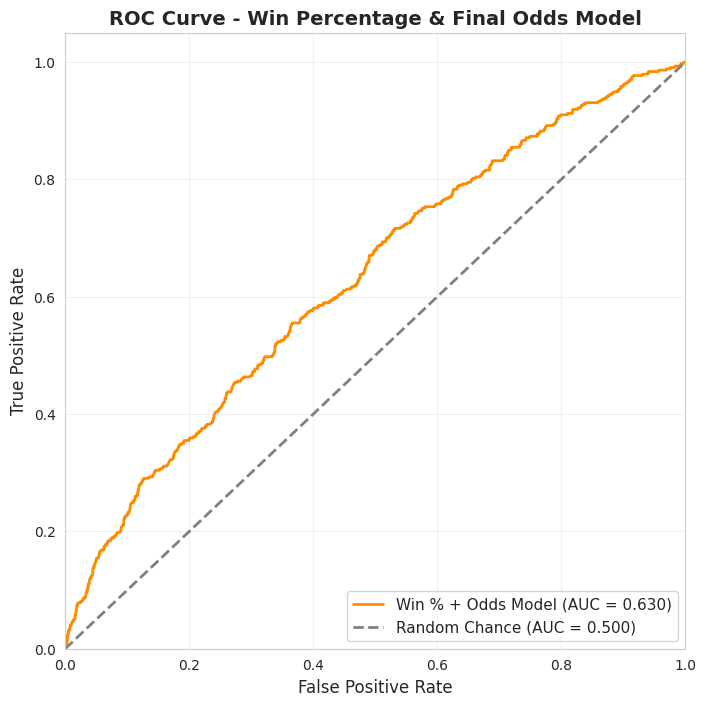

In [7]:
# Cell 6: Model Performance
# Get predicted probabilities
y_pred_proba_train = result.predict(X_train_const)
y_pred_proba_test = result.predict(X_test_const)

# Calculate ROC-AUC
train_auc = roc_auc_score(y_train, y_pred_proba_train)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

print("=" * 70)
print("MODEL PERFORMANCE - FINAL ODDS MODEL")
print("=" * 70)
print("\nROC-AUC Score:")
print(f"  Training set: {train_auc:.4f}")
print(f"  Test set: {test_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Win % + Odds Model (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
         label='Random Chance (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Win Percentage & Final Odds Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

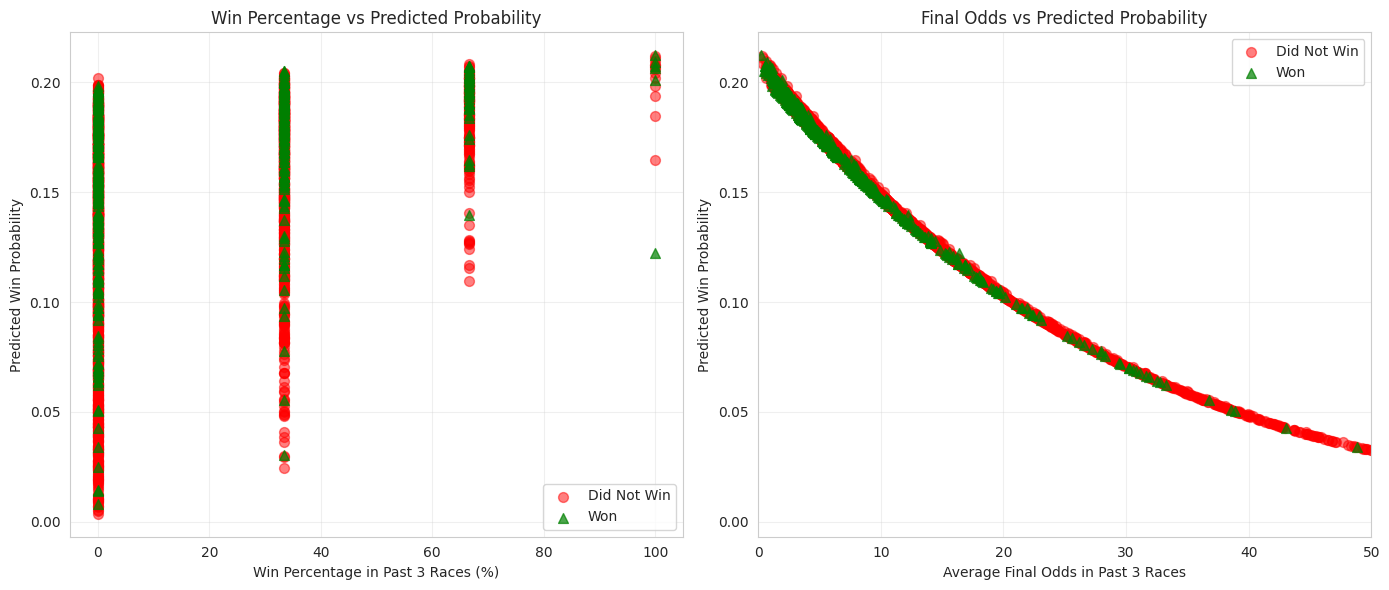

In [8]:
# Cell 7: Feature Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Win percentage vs predicted probability
test_results = X_test.copy()
test_results['predicted_win_prob'] = y_pred_proba_test
test_results['actual_win_flag'] = y_test.values

axes[0].scatter(test_results[test_results['actual_win_flag']==0]['win_percentage_past_3'],
               test_results[test_results['actual_win_flag']==0]['predicted_win_prob'],
               alpha=0.5, color='red', label='Did Not Win', s=50)
axes[0].scatter(test_results[test_results['actual_win_flag']==1]['win_percentage_past_3'],
               test_results[test_results['actual_win_flag']==1]['predicted_win_prob'],
               alpha=0.7, color='green', label='Won', s=50, marker='^')
axes[0].set_xlabel('Win Percentage in Past 3 Races (%)')
axes[0].set_ylabel('Predicted Win Probability')
axes[0].set_title('Win Percentage vs Predicted Probability')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Final odds vs predicted probability
axes[1].scatter(test_results[test_results['actual_win_flag']==0]['avg_final_odds_past_3'],
               test_results[test_results['actual_win_flag']==0]['predicted_win_prob'],
               alpha=0.5, color='red', label='Did Not Win', s=50)
axes[1].scatter(test_results[test_results['actual_win_flag']==1]['avg_final_odds_past_3'],
               test_results[test_results['actual_win_flag']==1]['predicted_win_prob'],
               alpha=0.7, color='green', label='Won', s=50, marker='^')
axes[1].set_xlabel('Average Final Odds in Past 3 Races')
axes[1].set_ylabel('Predicted Win Probability')
axes[1].set_title('Final Odds vs Predicted Probability')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 50)  # Limit x-axis for better visualization

plt.tight_layout()
plt.show()

In [9]:
# Cell 8: Compare All Models
all_models_df = pd.DataFrame({
    'Analysis': [
        'Logistic Regression (Win Rate + Speed)',
        'Logistic Regression (Win % + Final Odds)',
        'XGBoost (2 features)',
        'XGBoost (14 features)'
    ],
    'AUC Score': [
        0.569,  # From previous analysis
        test_auc,  # Current analysis
        0.557,  # From XGBoost with 2 features
        0.606   # From XGBoost with all features (CORRECTED)
    ],
    'Features': [
        'win_rate, avg_speed_figure',
        'win_percentage, avg_final_odds',
        'win_rate, avg_speed_figure',
        '14 engineered features'
    ],
    'Key Finding': [
        'Only win rate significant (p<0.001)',
        f'{"Both significant" if coef_df[coef_df["Feature"]!="const"]["P-value"].max() < 0.05 else "Check p-values"}',
        'Minimal improvement over logistic regression',
        'Best performance with feature engineering'
    ]
})

display(all_models_df)

print("\n" + "=" * 70)
print("KEY INSIGHTS ACROSS ALL ANALYSES")
print("=" * 70)
print("\n1. CONSISTENT FINDINGS:")
print("   • Past win performance is the strongest single predictor")
print("   • Simple historical metrics provide limited predictive power")
print("   • All models perform only modestly better than chance (AUC 0.557-0.606)")
print("\n2. MODEL EVOLUTION:")
print("   • Basic logistic regression: AUC ~0.57")
print("   • Enhanced features + XGBoost: AUC 0.606")
print("   • Improvement is meaningful but still indicates high inherent randomness")
print("\n3. BUSINESS IMPLICATIONS:")
print("   • Models can provide slight edge in ranking horses")
print("   • Not sufficient for high-confidence betting")
print("   • Additional data sources needed for practical application")

,Analysis,AUC Score,Features,Key Finding
0,Logistic Regression (Win Rate + Speed),0.56900,"win_rate, avg_speed_figure",Only win rate significant (p<0.001)
1,Logistic Regression (Win % + Final Odds),0.62951,"win_percentage, avg_final_odds",Check p-values
2,XGBoost (2 features),0.55700,"win_rate, avg_speed_figure",Minimal improvement over logistic regression
3,XGBoost (14 features),0.60600,14 engineered features,Best performance with feature engineering



KEY INSIGHTS ACROSS ALL ANALYSES

1. CONSISTENT FINDINGS:
   • Past win performance is the strongest single predictor
   • Simple historical metrics provide limited predictive power
   • All models perform only modestly better than chance (AUC 0.557-0.606)

2. MODEL EVOLUTION:
   • Basic logistic regression: AUC ~0.57
   • Enhanced features + XGBoost: AUC 0.606
   • Improvement is meaningful but still indicates high inherent randomness

3. BUSINESS IMPLICATIONS:
   • Models can provide slight edge in ranking horses
   • Not sufficient for high-confidence betting
   • Additional data sources needed for practical application


---

#### Next, go to `notebooks/past_performance/xgboost_logistic_analysis.ipynb` for the next analysis.